In [1]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 30, 20, 80, [150, 200, 250, 300, 350], None, None, None, reduce_da=True
)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = exp_T.da

In [12]:
net, centers, labels = exp_s.som_cluster(
    8,
    6,
    200,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=100, start_learning_rate=0.05),
)
jet_finder = JetFinder(
    preprocess=preprocess,
    cluster=partial(cluster_criterion, criterion_threshold=6.5, min_size=300),
    refine_jets=jets_from_mask,
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
centers_all_jets = jet_finder.call(xr.Dataset({"s": centers}), processes=1)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds_uncat = props_to_ds(centers_props, centers.cluster)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)
mask = labels_to_mask(labels)
labels = xr.DataArray(labels, coords={"time": da_T.time.values})

100%|██████████| 48/48 [00:01<00:00, 29.35it/s]


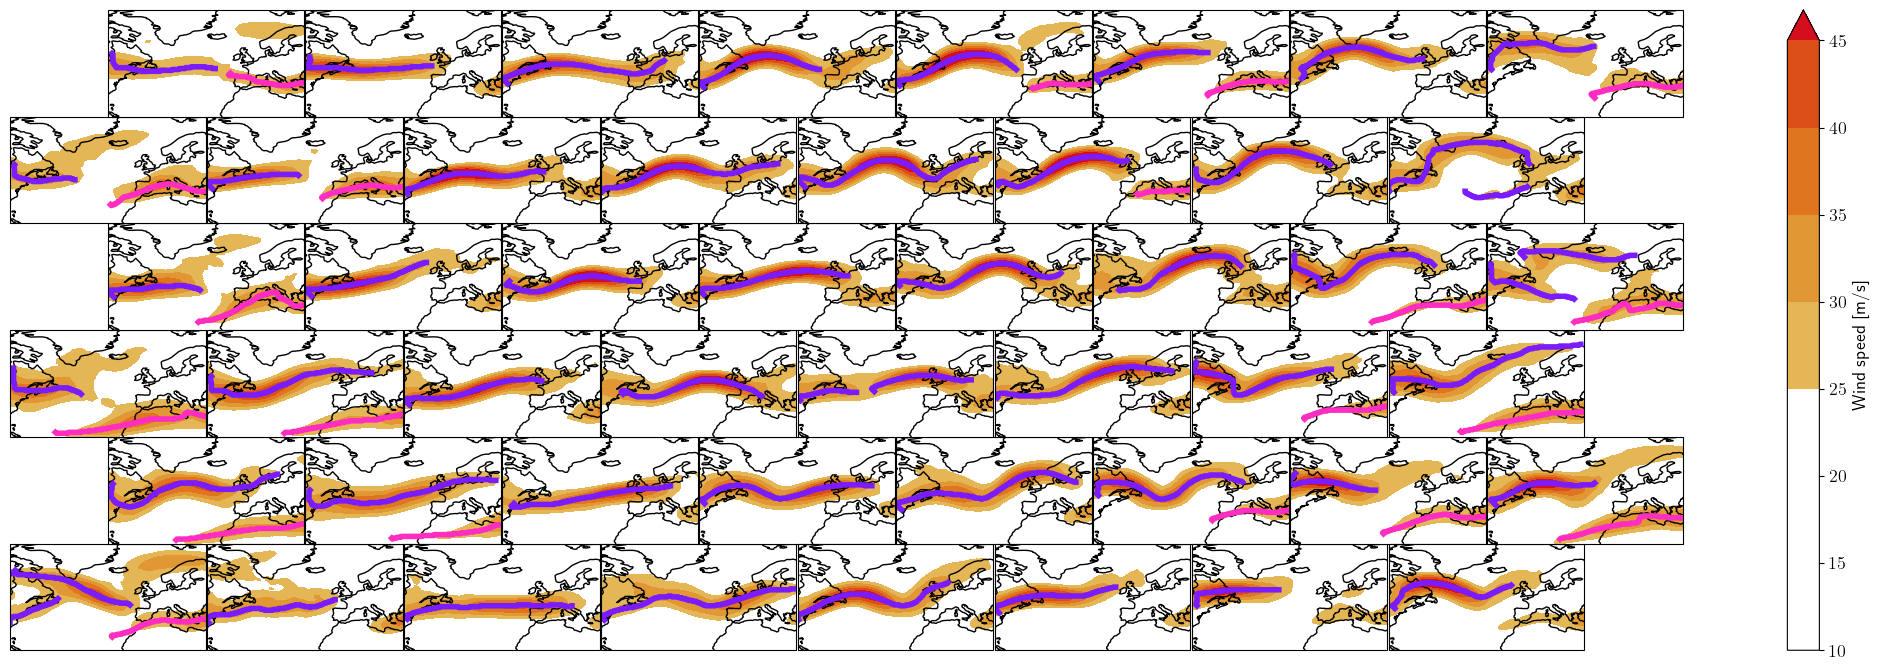

In [13]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    transparify=3,
    nlevels=8,
    cbar_kwargs={"label": "Wind speed [m/s]"}
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/wind.png', **SAVE_KWARGS)

100%|██████████| 48/48 [00:00<00:00, 73.39it/s]


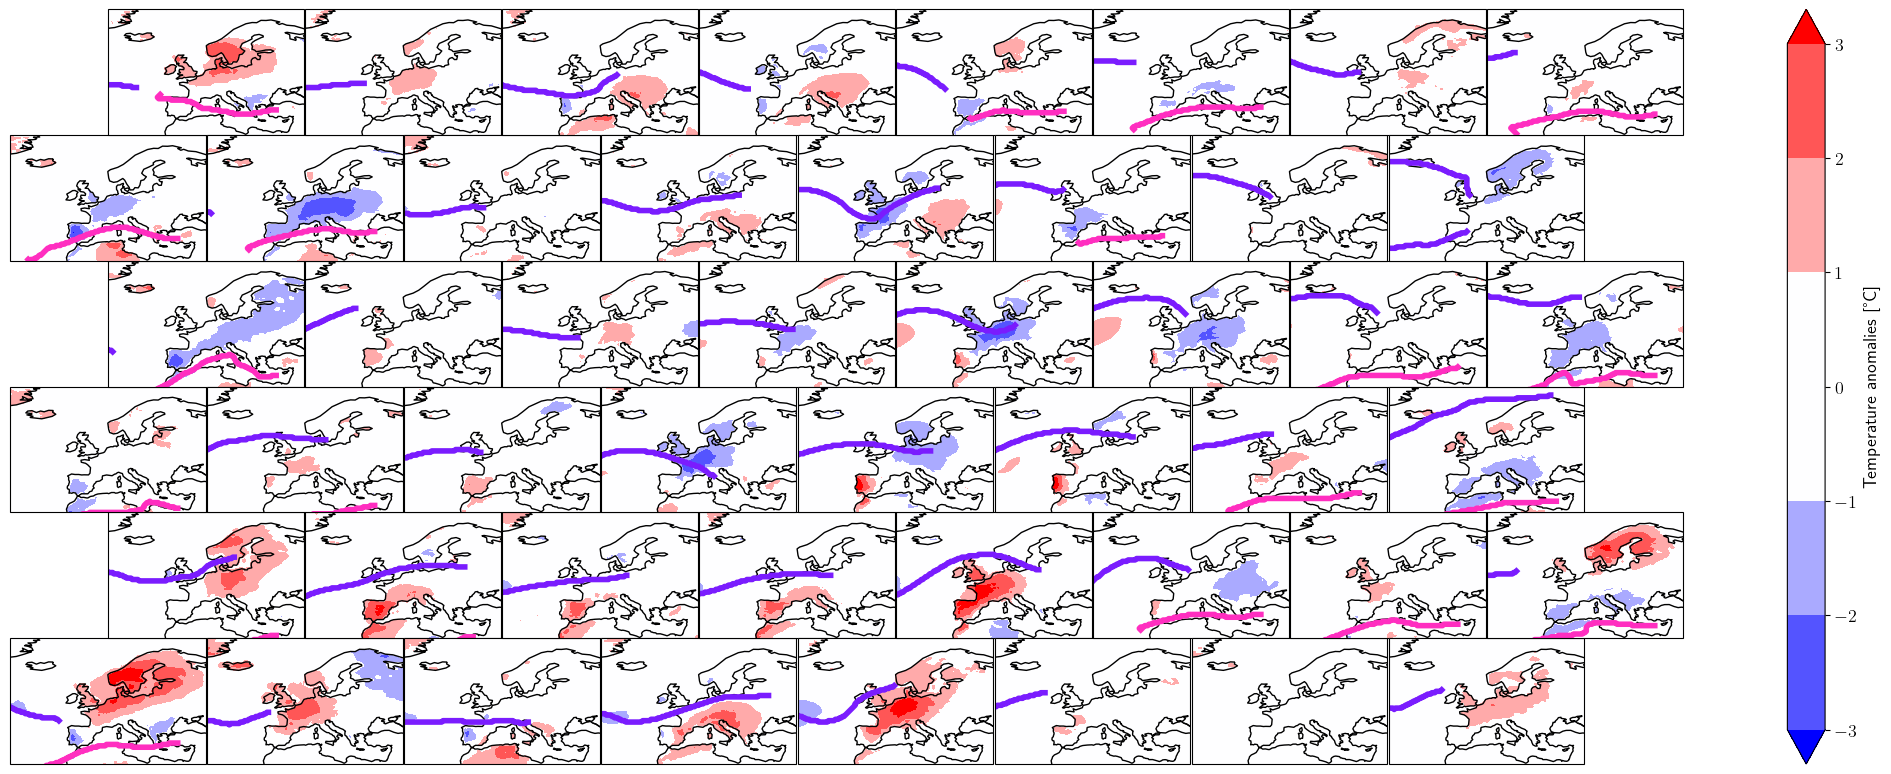

In [14]:
clu = Clusterplot(net.height, net.width, exp_T.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask, "contourf", stippling=False, cbar_label="Temperature anomalies [°C]", cmap='bwr', q=0.999
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/temp.png', **SAVE_KWARGS)

In [15]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da
s_to_pvs = np.isin(labels.time.values, da_pvs.time.values)

100%|██████████| 48/48 [00:02<00:00, 21.11it/s]


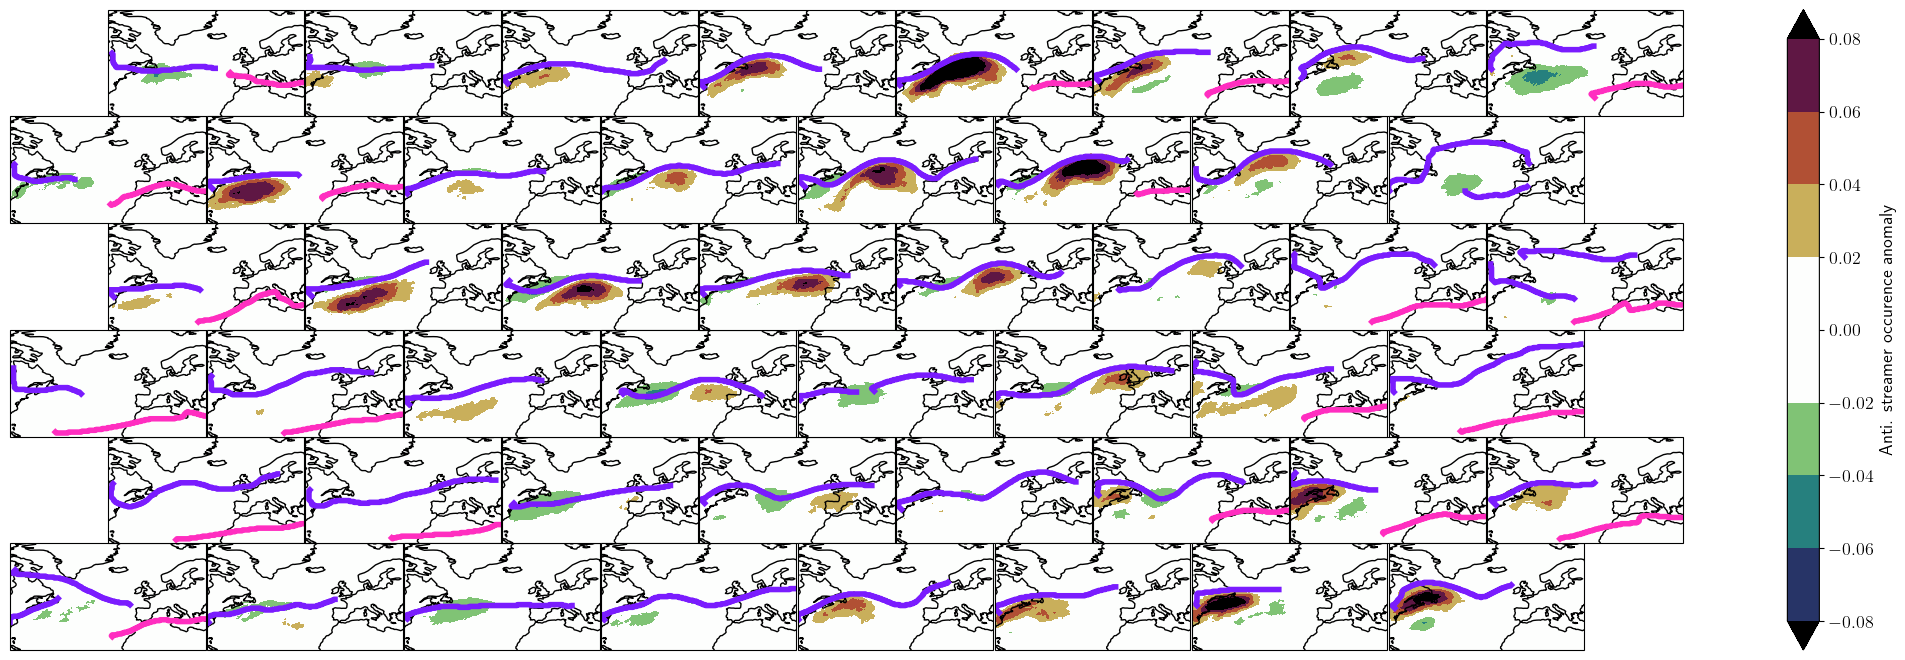

In [16]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'anti'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Anti. streamer occurence anomaly", cmap=colormaps.seasons, q=0.998
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/apvs.png', **SAVE_KWARGS)

 19%|█▉        | 9/48 [00:00<00:02, 18.25it/s]

100%|██████████| 48/48 [00:02<00:00, 21.02it/s]


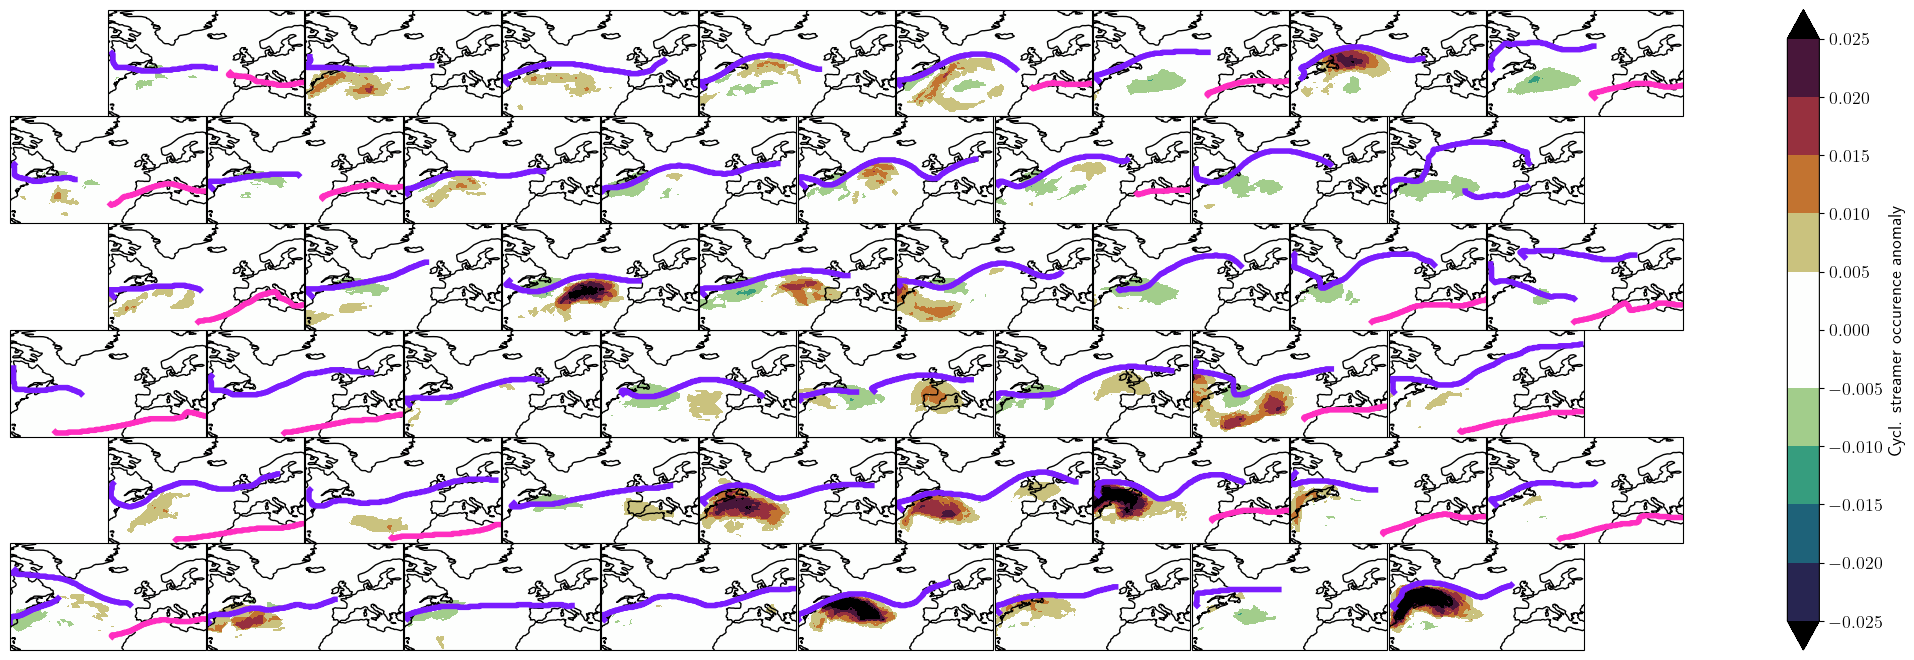

In [17]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'cycl'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Cycl. streamer occurence anomaly", cmap=colormaps.seasons, q=0.997
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/cpvs.png', **SAVE_KWARGS)

In [18]:
da_jet_pos = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/1/jet_pos.nc")
da_jet_pos = da_jet_pos.sel(time=da_jet_pos.time.dt.season=="JJA")

100%|██████████| 48/48 [00:02<00:00, 21.12it/s]


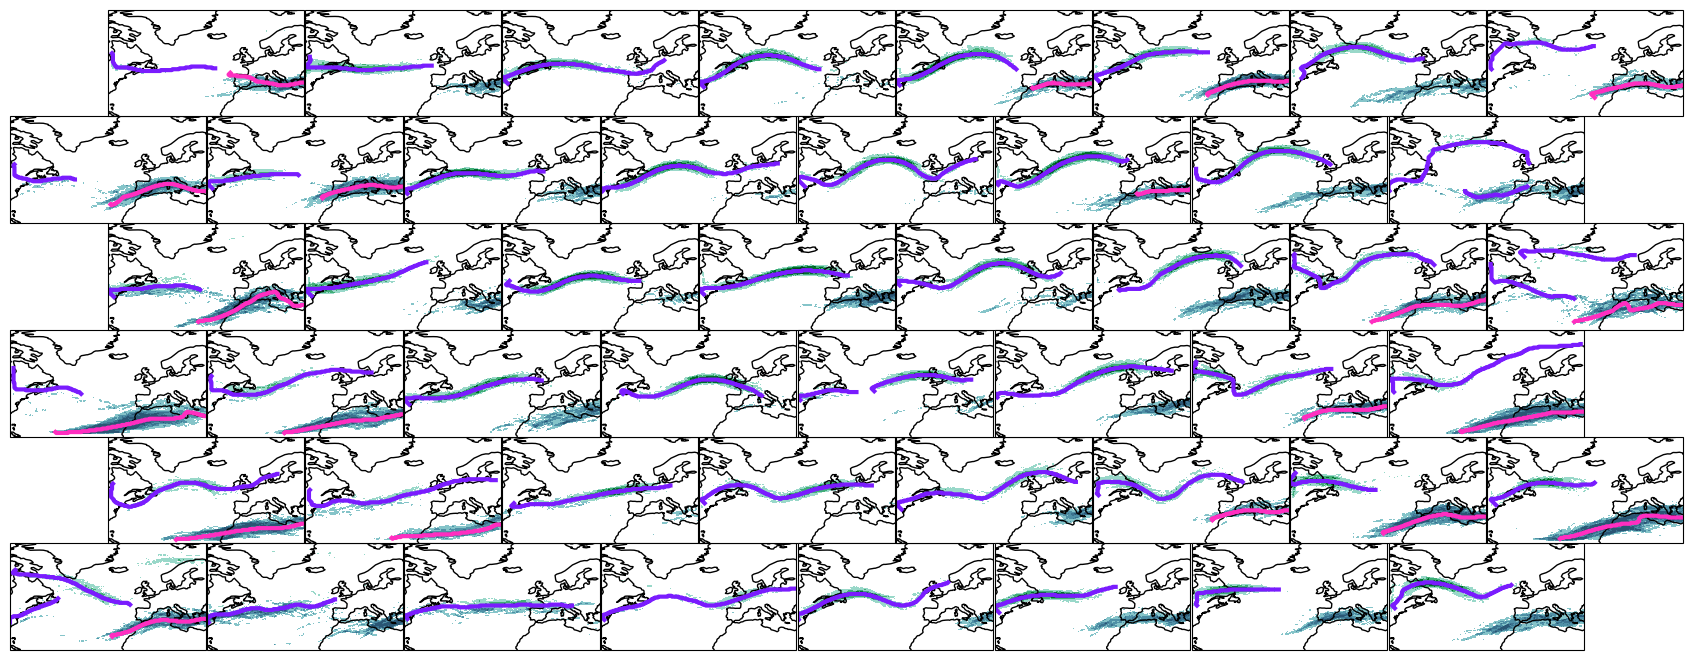

In [30]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 0] / da_jet_pos[:, 0].max(), mask, cbar_label="Subtropical jet occurence", transparify=2, cmap=colormaps.tempo, draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    da_jet_pos[:, 1] / da_jet_pos[:, 1].max(), mask, cbar_label="Polar jet occurence", transparify=2, cmap=colormaps.turbid, draw_cbar=False,
)
for ax, jets, are_polar in zip(clu.axes, centers_all_jets, centers_props_ds_uncat["is_polar"].values):
    for j, (jet, is_polar) in enumerate(zip(jets, are_polar)):
        x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
        ax.plot(x, y, color=COLORS[2 - int(is_polar)], ls="solid", lw=3)

clu.fig.set_size_inches(*(clu.fig.get_size_inches() * np.array([0.8, 1])))
clu.fig.savefig(f'{FIGURES}/som_composites/jet_pos.png', **SAVE_KWARGS)

In [26]:
exp_z = Experiment(
    "ERA5", "plev", "z", "6H", "all", "JJA", -80, 30, 20, 80, 500, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)

100%|██████████| 48/48 [00:01<00:00, 34.06it/s]


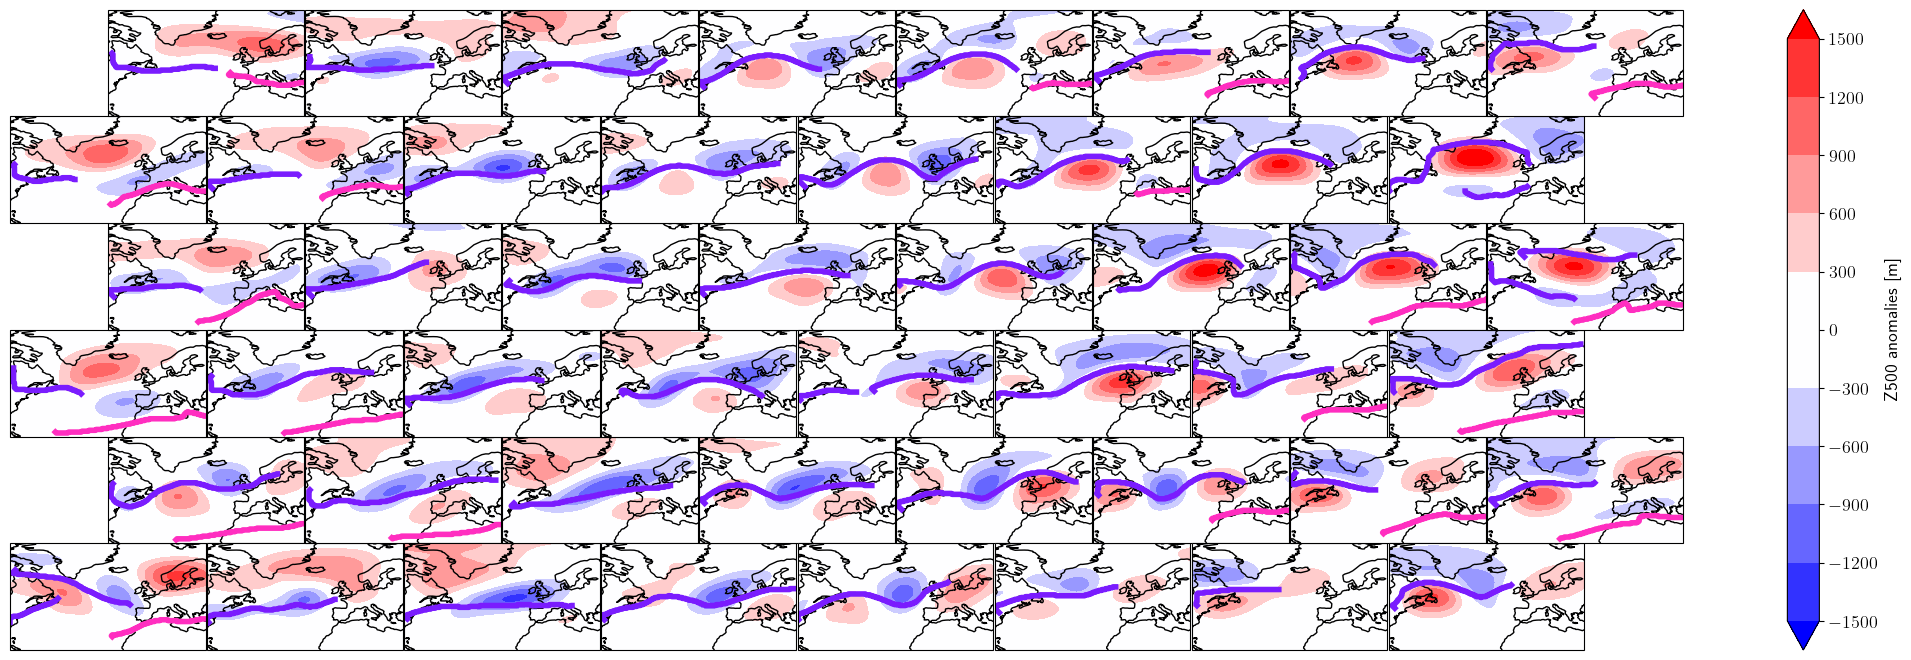

In [29]:
da_z = exp_z.da
clu = Clusterplot(net.height, net.width, exp_z.region, honeycomb=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_z, mask, "contourf", stippling=False, cbar_label="Z500 anomalies [m]", cmap='bwr', q=0.993, nlevels=6,
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/z500.png', **SAVE_KWARGS)